In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

#import sys
##sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [17]:
task = 'xvalidation'
pr_units = 'mm'
tasmax_units = 'degC'
gcms_tasmax = ['CSIRO-ACCESS-ESM1-5', 'EC-Earth-Consortium-EC-Earth3']
gcms = ['CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
rcms = ['BOM-BARPA-R', 'CSIRO-CCAM-2203']

In [3]:
def get_assessment_time_bounds(task):
    """Get assessment time bounds for given GCM/task combination"""

    start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date

In [4]:
start_date, end_date = get_assessment_time_bounds(task)

In [5]:
# Metric calculation

def calc_mean(da, var):
    """Calculate the mean"""
    
    if var == 'pr':
        mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
    else:
        mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [6]:
def get_obs_data(var, start_date, end_date):
    """Get obs data"""
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return calc_mean(da_obs, var)


def get_gcm_data(var, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    try:
        da_gcm = utils.get_npcp_data(var, gcm, 'GCM', 'raw', 'task-reference', start_date, end_date)
        return calc_mean(da_gcm, var)
    except OSError:
        print(f"Warning: GCM raw data for {gcm} is missing for the period {start_date} to {end_date}.")
        return None
    

def get_rcm_data(var, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']

    try:
        da_rcm = utils.get_npcp_data(var, gcm, rcm, 'raw', 'task-reference', start_date, end_date)
        return calc_mean(da_rcm, var)
    except OSError:
        print(f"Warning: RCM raw data for {gcm}/{rcm} is missing for the period {start_date} to {end_date}.")
        return None


def get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    bc_methods = ['ecdfm', 'qme', 'mrnbc']

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, rcm, bc, f'task-{task}', start_date, end_date)
            da_dict[bc] = calc_mean(da, var)
        except OSError:
            print(f"Warning: Bias corrected RCM data for {gcm}/{rcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict

In [7]:
if pr_units == '%':
    da_obs_pr = get_obs_data('pr', start_date, end_date)

In [18]:
def get_gcm_diff(var):
    """Get GCM difference data"""

    gcm_dict = {}
    gcm_list = gcms_tasmax if var == 'tasmax' else gcms
    for gcm in gcm_list:
        gcm_dict[gcm] = get_gcm_data(var, gcm, start_date, end_date)
    da_gcms = xr.concat(gcm_dict.values(), dim='gcm')
    da_gcm_max = da_gcms.max(dim='gcm')
    da_gcm_min = da_gcms.min(dim='gcm')
    da_gcm_diff = da_gcm_max - da_gcm_min
    da_gcm_diff = da_gcm_diff.compute()

    return da_gcm_diff

In [11]:
def get_rcm_diff(var):
    """Get RCM difference data"""
    
    rcm_dict = {}
    rcm_diff_dict = {}
    for gcm in gcms:
        rcm_dict[gcm] = {}
        for rcm in rcms:
            rcm_dict[gcm][rcm] = get_rcm_data(var, gcm, rcm, start_date, end_date)
        da_rcms = xr.concat(rcm_dict[gcm].values(), dim='rcm')
        da_rcm_max = da_rcms.max(dim='rcm')
        da_rcm_min = da_rcms.min(dim='rcm')
        da_rcm_diff = da_rcm_max - da_rcm_min
        rcm_diff_dict[gcm] = da_rcm_diff.compute()
    da_rcm_diff = xr.concat(rcm_diff_dict.values(), dim='gcm')
    da_rcm_diff = da_rcm_diff.mean(dim='gcm')

    return da_rcm_diff

In [14]:
def get_bc_diff(var):
    """Get bias correction difference data."""

    bc_dict = {}
    bc_diff_dict = {}
    for gcm in gcms:
        for rcm in rcms:
            bc_dict[(gcm, rcm)] = get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date)
            da_bcs = xr.concat(bc_dict[(gcm, rcm)].values(), dim='bc')
            da_bc_max = da_bcs.max(dim='bc')
            da_bc_min = da_bcs.min(dim='bc')
            da_bc_diff = da_bc_max - da_bc_min
            bc_diff_dict[(gcm, rcm)] = da_bc_diff.compute()
    da_bc_diff = xr.concat(bc_diff_dict.values(), dim='gcm-rcm')
    da_bc_diff = da_bc_diff.mean(dim='gcm-rcm')

    return da_bc_diff

In [15]:
da_gcm_diff_pr = get_gcm_diff('pr')

In [19]:
da_gcm_diff_tasmax = get_gcm_diff('tasmax')

In [20]:
da_rcm_diff_pr = get_rcm_diff('pr')

In [21]:
da_rcm_diff_tasmax = get_rcm_diff('tasmax')

In [22]:
da_bc_diff_pr = get_bc_diff('pr')

In [23]:
da_bc_diff_tasmax = get_bc_diff('tasmax')

In [24]:
# tasmax data
gcm_diff_tasmax = utils.clip_data(da_gcm_diff_tasmax, utils.get_aus_shape())
rcm_diff_tasmax = utils.clip_data(da_rcm_diff_tasmax, utils.get_aus_shape())
bc_diff_tasmax = utils.clip_data(da_bc_diff_tasmax, utils.get_aus_shape())
mean_gcm_diff_tasmax = float(np.nanmean(gcm_diff_tasmax))
max_gcm_diff_tasmax = float(np.nanmax(gcm_diff_tasmax))
mean_rcm_diff_tasmax = float(np.nanmean(rcm_diff_tasmax))
max_rcm_diff_tasmax = float(np.nanmax(rcm_diff_tasmax))
mean_bc_diff_tasmax = float(np.nanmean(bc_diff_tasmax))
max_bc_diff_tasmax = float(np.nanmax(bc_diff_tasmax))

# pr data
if pr_units == '%':
    da_gcm_frac_pr = (da_gcm_diff_pr / da_obs_pr) * 100
    da_rcm_frac_pr = (da_rcm_diff_pr / da_obs_pr) * 100
    da_bc_frac_pr = (da_bc_diff_pr / da_obs_pr) * 100
    gcm_diff_pr = utils.clip_data(da_gcm_frac_pr, utils.get_aus_shape())
    rcm_diff_pr = utils.clip_data(da_rcm_frac_pr, utils.get_aus_shape())
    bc_diff_pr = utils.clip_data(da_bc_frac_pr, utils.get_aus_shape())
else:
    gcm_diff_pr = utils.clip_data(da_gcm_diff_pr, utils.get_aus_shape())
    rcm_diff_pr = utils.clip_data(da_rcm_diff_pr, utils.get_aus_shape())
    bc_diff_pr = utils.clip_data(da_bc_diff_pr, utils.get_aus_shape())
ob_fractions = utils.get_pr_weights(gcms[0], task)
gcm_diff_pr = utils.mask_by_pr_ob_fraction(gcm_diff_pr, ob_fractions, threshold=0.9)
rcm_diff_pr = utils.mask_by_pr_ob_fraction(rcm_diff_pr, ob_fractions, threshold=0.9)
bc_diff_pr = utils.mask_by_pr_ob_fraction(bc_diff_pr, ob_fractions, threshold=0.9)

mean_gcm_diff_pr = float(np.nanmean(gcm_diff_pr))
max_gcm_diff_pr = float(np.nanmax(gcm_diff_pr))
mean_rcm_diff_pr = float(np.nanmean(rcm_diff_pr))
max_rcm_diff_pr = float(np.nanmax(rcm_diff_pr))
mean_bc_diff_pr = float(np.nanmean(bc_diff_pr))
max_bc_diff_pr = float(np.nanmax(bc_diff_pr))

In [28]:
levels_tasmax = np.arange(0, 4, 0.4)
if pr_units == '%':
    levels_pr = np.array([0, 20, 40, 60, 80, 100, 120, 140])
else:
    levels_pr = np.arange(0, 700, 70)

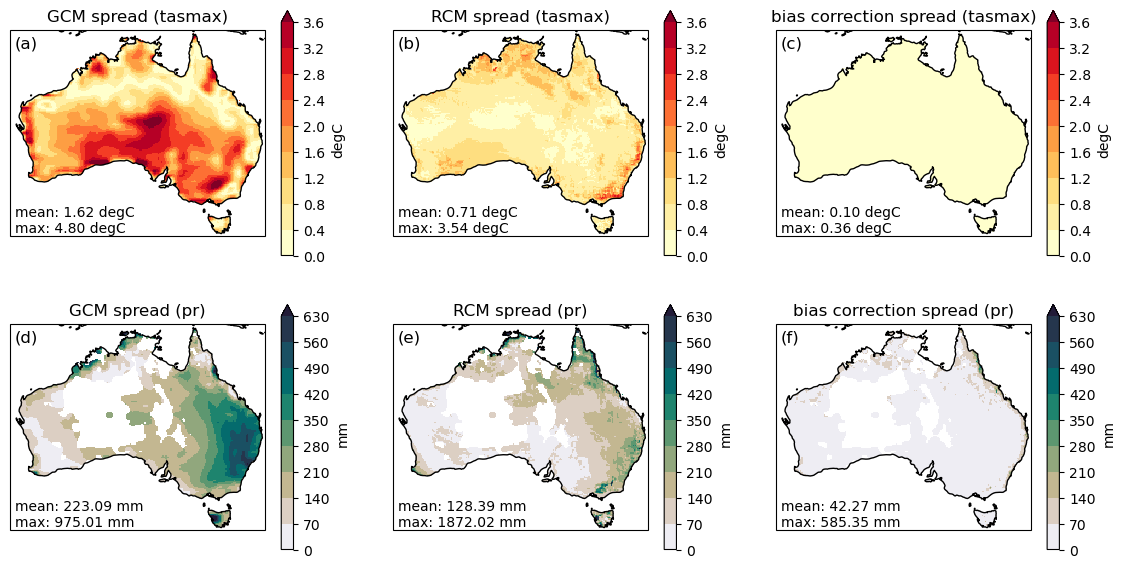

In [44]:
cmap_tasmax = 'YlOrRd'
cmap_pr = cmocean.cm.rain

fig = plt.figure(figsize=[14, 7])

ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree())
im1 = gcm_diff_tasmax.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmap_tasmax,
    levels=levels_tasmax,
    extend='max',
    cbar_kwargs={'label': tasmax_units},
)
ax1.set_title('GCM spread (tasmax)', fontsize='large')
ax1.text(0.02, 0.91, '(a)', transform=ax1.transAxes, fontsize='large')
ax1.text(0.02, 0.10, f'mean: {mean_gcm_diff_tasmax:.2f} {tasmax_units}', transform=ax1.transAxes, fontsize='medium')
ax1.text(0.02, 0.02, f'max: {max_gcm_diff_tasmax:.2f} {tasmax_units}', transform=ax1.transAxes, fontsize='medium')
ax1.coastlines()

ax2 = fig.add_subplot(232, projection=ccrs.PlateCarree())
im2 = rcm_diff_tasmax.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap_tasmax,
    levels=levels_tasmax,
    extend='max',
    cbar_kwargs={'label': tasmax_units},
)
ax2.set_title('RCM spread (tasmax)')
ax2.text(0.02, 0.91, '(b)', transform=ax2.transAxes, fontsize='large')
ax2.text(0.02, 0.10, f'mean: {mean_rcm_diff_tasmax:.2f} {tasmax_units}', transform=ax2.transAxes, fontsize='medium')
ax2.text(0.02, 0.02, f'max: {max_rcm_diff_tasmax:.2f} {tasmax_units}', transform=ax2.transAxes, fontsize='medium')
ax2.coastlines()

ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree())
im3 = bc_diff_tasmax.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=cmap_tasmax,
    levels=levels_tasmax,
    extend='max',
    cbar_kwargs={'label': tasmax_units},
)
ax3.set_title('bias correction spread (tasmax)')
ax3.text(0.02, 0.91, '(c)', transform=ax3.transAxes, fontsize='large')
ax3.text(0.02, 0.10, f'mean: {mean_bc_diff_tasmax:.2f} {tasmax_units}', transform=ax3.transAxes, fontsize='medium')
ax3.text(0.02, 0.02, f'max: {max_bc_diff_tasmax:.2f} {tasmax_units}', transform=ax3.transAxes, fontsize='medium')
ax3.coastlines()

ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree())
im4 = gcm_diff_pr.plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),
    cmap=cmap_pr,
    levels=levels_pr,
    extend='max',
    cbar_kwargs={'label': pr_units},
)
ax4.set_title('GCM spread (pr)')
ax4.text(0.02, 0.91, '(d)', transform=ax4.transAxes, fontsize='large')
ax4.text(0.02, 0.10, f'mean: {mean_gcm_diff_pr:.2f} {pr_units}', transform=ax4.transAxes, fontsize='medium')
ax4.text(0.02, 0.02, f'max: {max_gcm_diff_pr:.2f} {pr_units}', transform=ax4.transAxes, fontsize='medium')
ax4.coastlines()

ax5 = fig.add_subplot(235, projection=ccrs.PlateCarree())
im5 = rcm_diff_pr.plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),
    cmap=cmap_pr,
    levels=levels_pr,
    extend='max',
    cbar_kwargs={'label': pr_units},
)
ax5.set_title('RCM spread (pr)')
ax5.text(0.02, 0.91, '(e)', transform=ax5.transAxes, fontsize='large')
ax5.text(0.02, 0.10, f'mean: {mean_rcm_diff_pr:.2f} {pr_units}', transform=ax5.transAxes, fontsize='medium')
ax5.text(0.02, 0.02, f'max: {max_rcm_diff_pr:.2f} {pr_units}', transform=ax5.transAxes, fontsize='medium')
ax5.coastlines()

ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree())
im6 = bc_diff_pr.plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),
    cmap=cmap_pr,
    levels=levels_pr,
    extend='max',
    cbar_kwargs={'label': pr_units},
)
ax6.set_title('bias correction spread (pr)')
ax6.text(0.02, 0.91, '(f)', transform=ax6.transAxes, fontsize='large')
ax6.text(0.02, 0.10, f'mean: {mean_bc_diff_pr:.2f} {pr_units}', transform=ax6.transAxes, fontsize='medium')
ax6.text(0.02, 0.02, f'max: {max_bc_diff_pr:.2f} {pr_units}', transform=ax6.transAxes, fontsize='medium')
ax6.coastlines()

plt.savefig('/g/data/ia39/npcp/code/results/figures/uncertainty.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()